In [7]:
#load modules
import numpy as np
import torch
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

In [8]:
##determined from the global error analysis on the test set
#this is fixed for the entire analysis
global_error = 8.2 #in m/s

In [9]:
model = torch.load('VIPER_model.pt') #load the MLP architecture 
model.load_state_dict(torch.load('VIPER_weights.pt')) #load the trained weights and biases
model.eval() #set the model to evaluation mode 

/Users/sr2/opt/anaconda3/envs/tf_env/lib/python3.8/site-packages/torch/serialization.py:799: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


RecursiveScriptModule(
  original_name=MLP
  (layers): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=Linear)
    (3): RecursiveScriptModule(original_name=ReLU)
    (4): RecursiveScriptModule(original_name=Linear)
    (5): RecursiveScriptModule(original_name=ReLU)
    (6): RecursiveScriptModule(original_name=Linear)
    (7): RecursiveScriptModule(original_name=ReLU)
    (8): RecursiveScriptModule(original_name=Linear)
    (9): RecursiveScriptModule(original_name=ReLU)
    (10): RecursiveScriptModule(original_name=MonteCarloDropout)
    (11): RecursiveScriptModule(original_name=Linear)
  )
)

In [10]:
#load the data
#this data has already been prepared using the process outlined in Figure A1
raw_df = pd.read_csv('example_day.csv')
raw_df

,mlt,mlat,glon,tec,peak_n,mlat_n,width_n,peak_s,mlat_s,width_s,...,PTC,DOP,AOP,doy,alt,f107,kp,sym_h_min,sym_h_max,sym_h_range
0,0,-29,-142.5,18.869566,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,75,500,134.199997,7,-8,3,11
1,1,-29,-142.5,18.876823,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,75,500,134.199997,7,-8,3,11
2,2,-29,-142.5,18.059132,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,75,500,134.199997,7,-8,3,11
3,3,-29,-142.5,16.752174,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,75,500,134.199997,7,-8,3,11
4,4,-29,-142.5,15.982532,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,75,500,134.199997,7,-8,3,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11323,19,29,172.5,21.291935,92.680228,12.807569,8.034898,86.336760,-12.679621,11.285940,...,2.13,25.49,1.77,75,500,134.199997,7,-8,3,11
11324,20,29,172.5,16.580801,78.395746,12.043993,7.993502,81.922636,-11.855155,11.322025,...,1.82,23.90,-1.10,75,500,134.199997,7,-8,3,11
11325,21,29,172.5,15.739682,72.622168,11.883412,8.207159,75.081612,-10.808213,11.289900,...,1.69,22.69,-0.83,75,500,134.199997,7,-8,3,11
11326,22,29,172.5,14.325197,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00,0.00,75,500,134.199997,7,-8,3,11


In [11]:
def load_test_date(df, samples=500):

        df = df.copy()

        #filter to equatorial region only
        df = df[df['mlat'].between(-5, 5)]

        df_2 = df.copy()
        #Convert circular features into signals (sin and cos)
        df_2['mlt_sin'] = np.sin(df_2['mlt']*(2.*np.pi/24))
        df_2['mlt_cos'] = np.cos(df_2['mlt']*(2.*np.pi/24))
        df_2['doy_sin'] = np.sin((df_2['doy']-1)*(2.*np.pi/365))
        df_2['doy_cos'] = np.cos((df_2['doy']-1)*(2.*np.pi/365))
        df_2['lon_sin'] = np.sin(df_2['glon']*(2.*np.pi/360))
        df_2['lon_cos'] = np.cos(df_2['glon']*(2.*np.pi/360))

        #Load the scaler to normalize the data using the same std and mean as the training data
        scaler_path = 'VIPER_scaler.pkl'

        #prepare the data for the model
        with open(scaler_path, 'rb') as f:
                scaler = pickle.load(f)
                col_names = df_2.columns.to_list()
                norm_arr = scaler.transform(df_2)
                df_2 = pd.DataFrame(norm_arr, columns=col_names)
                df_2 = df_2.drop(columns=['mlt','mlat','glon'])

        #make predictions of vertical drift with VIPER
        df['vz_pred'] = model(torch.tensor(df_2.values).float()).detach().numpy()

        #calculate the median absolute deviation (MAD) of the predictions using Monte Carlo dropout
        samples_list = []
        for i in range(samples):
                mc_preds = model(torch.tensor(df_2.values).float()).detach().numpy()
                samples_list.append(mc_preds)
        samples = np.array(samples_list)
        median = np.median(samples, axis=0)
        median_abs_dev = np.median(np.abs(samples - median), axis=0)

        df['MAD'] = median_abs_dev #add MAD to original dataframe
        df['error'] = df['MAD'] + global_error #add MC error to global error
        
        #additional filters to aid interpretation 
        df = df[['mlt','mlat','glon','vz_pred','error']]
        df = df[df['glon'] < 0]
        
        return df

pred_df = load_test_date(raw_df)
pred_df

/Users/sr2/opt/anaconda3/envs/tf_env/lib/python3.8/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/sr2/opt/anaconda3/envs/tf_env/lib/python3.8/site-packages/sklearn/base.py:402: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


,mlt,mlat,glon,vz_pred,error
576,0,-5,-142.5,-31.577497,9.955573
577,1,-5,-142.5,-21.401098,9.545844
578,2,-5,-142.5,-24.895229,9.395143
579,3,-5,-142.5,-35.645470,9.976035
580,4,-5,-142.5,-41.057472,10.419101
...,...,...,...,...,...
5083,19,5,-7.5,11.041423,9.058031
5084,20,5,-7.5,14.559921,9.236669
5085,21,5,-7.5,6.154117,8.930837
5086,22,5,-7.5,2.257451,8.817802


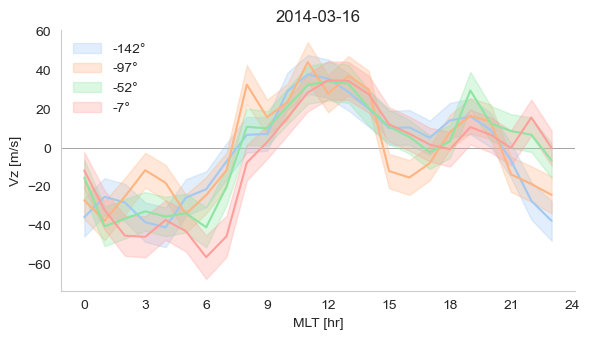

In [12]:
def plot_vz(df):
        
        #convert the data to a pivot table for plotting
        df_piv = pred_df.groupby(['mlt', 'glon']).mean().reset_index()
        df_piv = df_piv.pivot(index='glon', columns='mlt', values='vz_pred')
        df_piv_mad = pred_df.groupby(['mlt', 'glon']).mean().reset_index()
        df_piv_mad = df_piv_mad.pivot(index='glon', columns='mlt', values='error')

        def piv_to_df(piv, name, lon_min, lon_max):
            df = piv.stack().reset_index()
            df.columns = ['glon', 'mlt', name]
            df = df[df['glon'].between(lon_min, lon_max)]
            return df
        
        #extract the vz for each longitude sector
        df_vz_1 = piv_to_df(df_piv, 'vz', -170, -100)
        df_vz_2 = piv_to_df(df_piv, 'vz', -125, -70)
        df_vz_3 = piv_to_df(df_piv, 'vz', -70, -42)
        df_vz_4 = piv_to_df(df_piv, 'vz', -42, -5)

        #extract the error for each longitude sector
        df_mad_1 = piv_to_df(df_piv_mad, 'error', -170, -100)
        df_mad_2 = piv_to_df(df_piv_mad, 'error',  -125, -70)
        df_mad_3 = piv_to_df(df_piv_mad, 'error',  -70, -42)
        df_mad_4 = piv_to_df(df_piv_mad, 'error',  -42, -5)

        #set the color scheme
        color = sns.color_palette('pastel', 8)
        color_hex = color.as_hex()

        #plot the data according to each longitude sector and fill the gaps with the error
        fig, ax = plt.subplots(1, 1, figsize=(6,3.5), sharey=True)

        ax.errorbar(df_vz_1['mlt'], df_vz_1['vz'], color=color_hex[0])
        ax.fill_between(df_vz_1['mlt'], df_vz_1['vz']-df_mad_1['error'], df_vz_1['vz']+df_mad_1['error'], alpha=0.3, color=color_hex[0])
        ax.errorbar(df_vz_2['mlt'], df_vz_2['vz'], color=color_hex[1])
        ax.fill_between(df_vz_2['mlt'], df_vz_2['vz']-df_mad_2['error'], df_vz_2['vz']+df_mad_2['error'], alpha=0.3, color=color_hex[1])
        ax.errorbar(df_vz_3['mlt'], df_vz_3['vz'], color=color_hex[2])
        ax.fill_between(df_vz_3['mlt'], df_vz_3['vz']-df_mad_3['error'], df_vz_3['vz']+df_mad_3['error'], alpha=0.3, color=color_hex[2])
        ax.errorbar(df_vz_4['mlt'], df_vz_4['vz'], color=color_hex[3])
        ax.fill_between(df_vz_4['mlt'], df_vz_4['vz']-df_mad_4['error'], df_vz_4['vz']+df_mad_4['error'], alpha=0.3, color=color_hex[3])  

        #decoration
        ax.legend(['-142°', '-97°', '-52°', '-7°'], loc='upper left',frameon=False)
        ax.set_title('2014-03-16')
        ax.set_xlabel('MLT [hr]')
        x = np.arange(0, 25, 3)
        ax.set_xticks(x)
        ax.set_ylabel('Vz [m/s]')
        ax.axhline(0, color='k', linestyle='-', alpha=0.5, linewidth=0.5, zorder=0) #line at 0 m/s
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)
        ax.tick_params(axis='x', direction='out')

        #save the plot
        plt.tight_layout()
        plt.savefig('example_day.png', dpi=600)

plot_vz(pred_df)